In [1]:
# download data from here https://www.kaggle.com/fivethirtyeight/uber-pickups-in-new-york-city

* exploratory analysis of the Uber Pickups in New York City data set.
* analysis looks at a single month of pick-up data.

In [6]:
!apt-get install -q libgeos-3.5.0
!apt-get install -q libgeos-dev
!pip install -q https://github.com/matplotlib/basemap/archive/master.zip
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
%matplotlib inline
!pip install -q pyproj==1.9.6

import time
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap

from matplotlib import cm

%matplotlib inline

from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

Reading package lists...
Building dependency tree...
Reading state information...
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists...
Building dependency tree...
Reading state information...
libgeos-dev is already the newest version (3.6.2-1build2).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [7]:
rides = pd.read_csv('/content/drive/MyDrive/project 10 uber data/data/uber-raw-data-aug14.csv')
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829275 entries, 0 to 829274
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Date/Time  829275 non-null  object 
 1   Lat        829275 non-null  float64
 2   Lon        829275 non-null  float64
 3   Base       829275 non-null  object 
dtypes: float64(2), object(2)
memory usage: 25.3+ MB


In [8]:
rides.head()

,Date/Time,Lat,Lon,Base
0,8/1/2014 0:03:00,40.7366,-73.9906,B02512
1,8/1/2014 0:09:00,40.7260,-73.9918,B02512
2,8/1/2014 0:12:00,40.7209,-74.0507,B02512
3,8/1/2014 0:12:00,40.7387,-73.9856,B02512
4,8/1/2014 0:12:00,40.7323,-74.0077,B02512


If possible, I like to remove special characters and capital letters from the column names.

In [9]:
rides.columns = ['timestamp', 'lat', 'lon', 'base']

Then we'll convert the "timestamp" entries to pandas Timestamp objects.

In [11]:
ti = time.time()

rides['timestamp'] = pd.to_datetime(rides['timestamp'])

tf = time.time()
print(tf-ti,' seconds.')

82.92543148994446  seconds.


Let's go ahead and save the data in a convenient format so we can load it to a new/reset kernel without having to convert the timestamp again.

The top line in the cell below will "pickle" the data. The bottom line will read the .pkl file to a pandas DataFrame.

In [12]:
# save this data will take long time to train
rides.to_pickle('./test_data.pkl')

We could try to use the Timestamp objects for the sorting and grouping which is required to make sense of this data set, but it will be much simpler to extract some features up front. We'll unpack the Timestamp into individual features using datetime methods. We want the weekday name, the month number, day number, hour number, and minute number all in separate columns.

We can also use pandas.Series.dt.strftime to extract additional features with customized formatting from the timestamp. It's not necessary for this analysis but I'll demonstrate it below. For now the lines will be commented out.

In [32]:
rides['weekday'] = rides.timestamp.dt.day_name()
rides['month'] = rides.timestamp.dt.month
rides['day'] = rides.timestamp.dt.day
rides['hour'] = rides.timestamp.dt.hour
rides['minute'] = rides.timestamp.dt.minute


In [33]:
rides.head()

,timestamp,lat,lon,base,weekday,month,day,hour,minute
0,2014-08-01 00:03:00,40.7366,-73.9906,B02512,Friday,8,1,0,3
1,2014-08-01 00:09:00,40.7260,-73.9918,B02512,Friday,8,1,0,9
2,2014-08-01 00:12:00,40.7209,-74.0507,B02512,Friday,8,1,0,12
3,2014-08-01 00:12:00,40.7387,-73.9856,B02512,Friday,8,1,0,12
4,2014-08-01 00:12:00,40.7323,-74.0077,B02512,Friday,8,1,0,12


Pandas lets us define an ordered categorical index. We'll choose the weekday; this will help with sorting later on.

In [34]:
day_map = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']

In [35]:
rides['weekday'] = pd.Categorical(rides['weekday'], categories=day_map, ordered=True)

Initial Exploration

In this section we'll aggregate the data into more useful metrics. Specifically, we'll calculate the total number of rides per hour for every hour in the month, and then use that data to calculate the average number of rides for each hour on a given weekday.

Hourly Ride Data

We'll count the rides for every hour in the month and retain the weekday feature. The groupby operation will assign a hierarchical index which we can reset. Also, we'll rename the column to indicate that it's a count of the total number of rides matching the criteria.

In [36]:
## groupby operation
hourly_ride_data = rides.groupby(['day','hour','weekday'])['timestamp'].count()

## reset index
hourly_ride_data = hourly_ride_data.reset_index()

## rename column
hourly_ride_data = hourly_ride_data.rename(columns = {'timestamp':'ride_count'})

## ocular analysis
hourly_ride_data.head()

,day,hour,weekday,ride_count
0,1,0,Monday,0
1,1,0,Tuesday,0
2,1,0,Wednesday,0
3,1,0,Thursday,0
4,1,0,Friday,734


Weekday Hourly Averages
Next, we'll use the hourly data to compute hourly averages for each weekday. We'll sort the data on the previously defined weekday index for clean plotting.

In [37]:
## groupby operation
weekday_hourly_avg = hourly_ride_data.groupby(['weekday','hour'])['ride_count'].mean()

## reset index
weekday_hourly_avg = weekday_hourly_avg.reset_index()

## rename column
weekday_hourly_avg = weekday_hourly_avg.rename(columns = {'ride_count':'average_rides'})

## sort by categorical index
weekday_hourly_avg = weekday_hourly_avg.sort_index()

## ocular analysis
weekday_hourly_avg.head()

,weekday,hour,average_rides
0,Monday,0,35.290323
1,Monday,1,22.064516
2,Monday,2,18.064516
3,Monday,3,38.258065
4,Monday,4,59.225806


Define Color Palette
Seaborn's default color blind palette only has six colors, which will cause a repeat for our weekday categorical data. The default color scheme is too bright for my taste, and while you can manually adjust the brightness and saturation in seaborn, it's easy to create colors which are not distinguishable for people with some degree of color blindness when using this approach.

Instead of wasting time hacking together a "functional" color palette, we'll use the Color Blind 10 from Tableau, with code from Randal Olson to convert from the published 0-255 format to the 0-1 format which matplotlib accepts.

In [38]:
tableau_color_blind = [(0, 107, 164), (255, 128, 14), (171, 171, 171), (89, 89, 89),
             (95, 158, 209), (200, 82, 0), (137, 137, 137), (163, 200, 236),
             (255, 188, 121), (207, 207, 207)]

for i in range(len(tableau_color_blind)):  
    r, g, b = tableau_color_blind[i]  
    tableau_color_blind[i] = (r / 255., g / 255., b / 255.)

seaborn
The seaborn package makes visualizing this data quick and convenient. With a single line of code, we'll plot the average pickup rate vs. hour of the day, for each individual day of the week. We can conveniently implement our custom Color Blind 10 color palette and format the plot using familiar matplotlib syntax.

Text(0.5, 0, 'Hour')

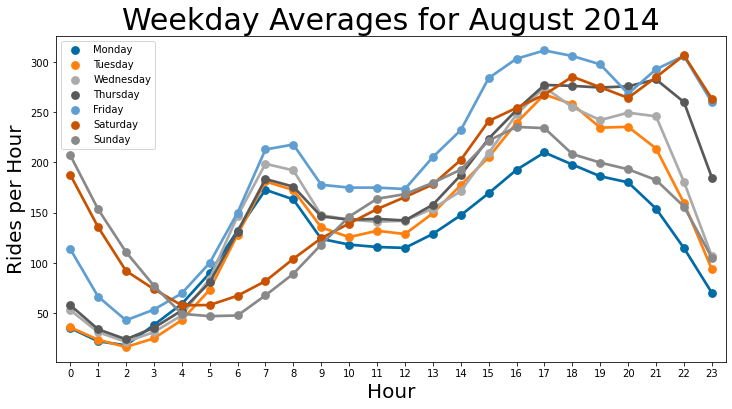

In [40]:
## create figure
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

## set palette   
current_palette = sns.color_palette(tableau_color_blind)

## plot data
sns.pointplot(ax=ax, x='hour',y='average_rides',hue='weekday', 
              palette = current_palette, data = weekday_hourly_avg)

## clean up the legend
l = ax.legend()
l.set_title('')
## format plot labels
ax.set_title('Weekday Averages for August 2014', fontsize=30)
ax.set_ylabel('Rides per Hour', fontsize=20)
ax.set_xlabel('Hour', fontsize=20)


Weekdays see a skewed bimodal distribution, with a smaller peak during the morning commute and a larger peak beginning at the close of business and continuing through evening social hours. Weekends do not experience a morning rush, but rise steadily throughout the day before diverging in the early evening. Thursday shows the largest evening volume. However, while Friday and Saturday nights plateau at lower levels than Thursday, the carryover into the early morning party hours (Sat/Sun morning 0-2 AM) is much more significant.


Spatial Visualization
Can we say anything about the location of these rides?

Let's build a function to help us plot the data on a map. We'll utilize the Basemap package to bin the results based on location to create a heat map. Basemap will use the hexbin method from matplotlib for the spatial binning. We'll set the zorder parameter so that the heat map is plotted on top of the continent fill.

In [41]:
def heat_map(ax_loc,title_str,rides_this_hour,nsew):
    
    ## get the axis
    ax = fig.add_subplot(ax_loc)

    ## make the basemap object
    m = Basemap(projection='merc', urcrnrlat=nsew[0], llcrnrlat=nsew[1],
                urcrnrlon=nsew[2], llcrnrlon=nsew[3], lat_ts=nsew[1], resolution='f')

    ## draw the background features
    m.drawmapboundary(fill_color = 'xkcd:light blue')
    m.fillcontinents(color='xkcd:grey', zorder = 1)
    m.drawcoastlines()
    m.drawrivers()

    ## project the GPS coordinates onto the x,y representation
    x, y = m(rides_this_hour['lon'].values, rides_this_hour['lat'].values)

    ## count the instances using the hexbin method and plot the results
    m.hexbin(x, y, gridsize=1000, mincnt = 1, bins = 'log', cmap=cm.YlOrRd, zorder = 2);

    ## set the title
    ax.set_title(title_str, fontsize=24)

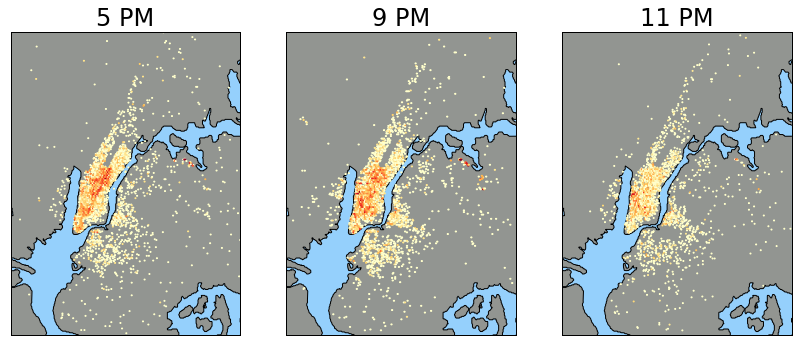

In [42]:
## set weekday for analysis
target_day = 'Thursday'

## north,south,east,west lat/lon coordinates for bounding box
nsew = [40.9, 40.6, -73.8, -74.1]

## create figure
fig = plt.figure(figsize=(14,8))

## target hours
hrs = [17, 21, 23]

## axis subplot locations
ax_loc = [131, 132, 133] 

## title strings
title_str = ['5 PM', '9 PM', '11 PM']

## plot loop
for ii in range(len(ax_loc)):

    ## get the ride data from the target hour
    rides_this_hour = rides.loc[(rides['weekday'] == target_day) & (rides['hour'] == hrs[ii])]

    ##  plot the heat map
    heat_map(ax_loc[ii],title_str[ii],rides_this_hour,nsew)

First, note that the default shape file included with the Basemap package does not have adequate resolution for this scale. The Hudson River is not visible, despite calling drawrivers(), and Manhatan appears as a peninsula. We'll need to use a higher resolution shape file for detailed analysis, but we can make some general conclusions based on our knowledge of the city. Central Park is a highly visible feature which we can use to orient ourselves.

As the workday is ending, the most concentrated traffic is in Midtown, slightly trending towards the Upper East Side. By 9:00 pm, some of the pressure north of Midtown is relaxing and hot spots are developing in other parts of the city. They appear close to Greenwich Village and Washington Square Park, with other small hot spots on the Hudson. By 11:00 pm, the total traffic has reduced and there's only one hot spot along the Hudson.

Still, this is average data for all Thursdays in the month. What if one particular Thursday skewed the results?

Daily Comparison

Luckily, we still have the hourly ride data.

In [43]:
hourly_ride_data.head()

,day,hour,weekday,ride_count
0,1,0,Monday,0
1,1,0,Tuesday,0
2,1,0,Wednesday,0
3,1,0,Thursday,0
4,1,0,Friday,734


So we can just grab all of the Thursday hourly data...

In [44]:
thursday_hourly_data = hourly_ride_data[hourly_ride_data['weekday']=='Thursday']

Text(0.5, 0, 'Hour')

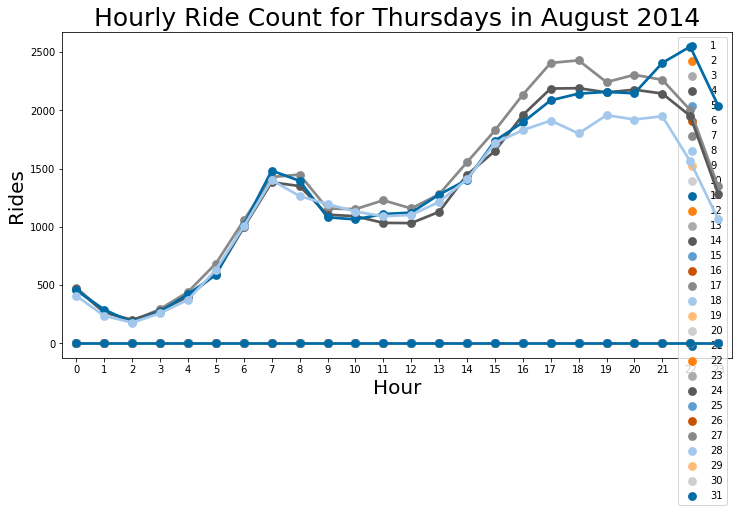

In [45]:
## create figure
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

## set palette   
current_palette = sns.color_palette(tableau_color_blind)

## plot data
sns.pointplot(ax=ax, x='hour',y='ride_count',hue='day', palette = current_palette, data = thursday_hourly_data)

## clean up the legend
l = ax.legend()
l.set_title('')

## format plot labels
ax.set_title('Hourly Ride Count for Thursdays in August 2014', fontsize=25)
ax.set_ylabel('Rides', fontsize=20)
ax.set_xlabel('Hour', fontsize=20)

There is some variation in the evening hours. Let's compare the highest hourly ride count (10 PM on Aug 21) to the same time on a "typical" Thursday.

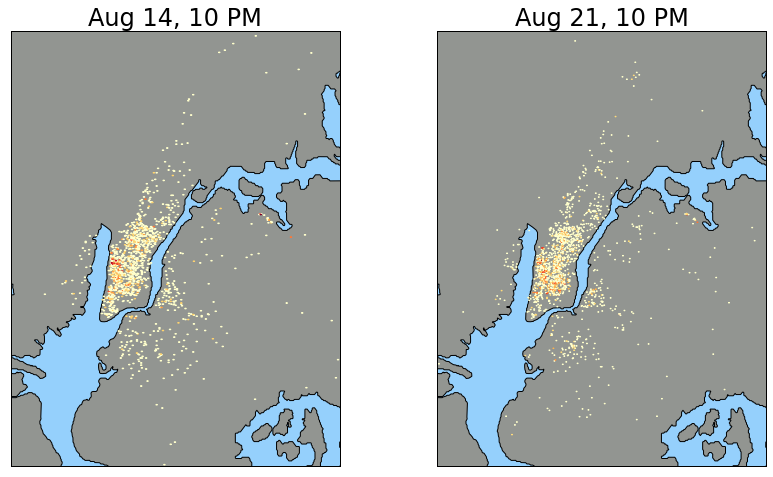

In [46]:
## set day for analysis
target_day = [14, 21]

## north,south,east,west lat/lon coordinates for bounding box
nsew = [40.9,40.6,-73.8,-74.1]

## create figure
fig = plt.figure(figsize=(14,8))

## hour 
hrs = 22

## axis locations
ax_loc = [121, 122] 

## title strings
title_str = ['Aug 14, 10 PM', 'Aug 21, 10 PM']

## plot loop
for ii in range(len(ax_loc)):

    ## get the ride data from the target hour
    rides_this_hour = rides.loc[(rides['day'] == target_day[ii]) & (rides['hour'] == hrs)]

    ## plot the heat map
    heat_map(ax_loc[ii],title_str[ii],rides_this_hour,nsew)

These results are ok. We can see one large cluster on the 14th and several distributed clusters on the 21st, but it's difficult to pinpoint the location. We really need a more detailed plot to keep asking questions. One option is to track down the relevant shape files to draw the city in more resolution, but it takes a long time for Basemap to process the data and make the plots anyway.

In [49]:
!pip install mplleaflet
import mplleaflet as mpl

  Created wheel for mplleaflet: filename=mplleaflet-0.0.5-cp37-none-any.whl size=28556 sha256=df26d36d7420ddf017f56190b92ebd967ca3a5c1aae4cb540dad86f8f5f617b9
  Stored in directory: /root/.cache/pip/wheels/bf/fd/0b/0513de62c339c4a56e2234aa42a5d06e6660a4446fdae7b796
Successfully built mplleaflet


In [50]:
## make the figure
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

## get ride data
rides_this_hour = rides.loc[(rides['day']== 14) & (rides['hour'] == 22) & (rides['minute'] < 16)]

## plot ride data
plt.plot(rides_this_hour['lon'], rides_this_hour['lat'], 'bo', markersize=4)

## display the Leaflet
# mpl.show()     # opens in a new interactive tab
mpl.display()  # shows interactive map inline in Jupyter but cannot handle large data sets

Clustering

While it can be useful to look at the raw data set and gain intuition, looking at snap shots doesn't give us enough information to make good conclusions, and plotting hours of individual pick-ups just makes a mess. We want actionable conclusions from this data set, so we'll need to be able to make quantitative comparisons between different regions in the city.

In [54]:
def get_hot_spots(max_distance,min_cars,ride_data):
    
    ## get coordinates from ride data
    coords = ride_data[['lat', 'lon']].to_numpy()
    
    ## calculate epsilon parameter using
    ## the user defined distance
    kms_per_radian = 6371.0088
    epsilon = max_distance / kms_per_radian
    
    ## perform clustering
    db = DBSCAN(eps=epsilon, min_samples=min_cars,
                algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    
    ## group the clusters
    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels))
    clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
    
    ## report
    print('Number of clusters: {}'.format(num_clusters))
    
    ## initialize lists for hot spots
    lat = []
    lon = []
    num_members = []
    
    ## loop through clusters and get centroids, number of members
    for ii in range(len(clusters)):

        ## filter empty clusters
        if clusters[ii].any():

            ## get centroid and magnitude of cluster
            lat.append(MultiPoint(clusters[ii]).centroid.x)
            lon.append(MultiPoint(clusters[ii]).centroid.y)
            num_members.append(len(clusters[ii]))
            
    hot_spots = [lon,lat,num_members]
    
    return hot_spots

In [55]:
## get ride data
ride_data = rides.loc[(rides['day']== 21) & (rides['hour'] > 15)]

## maximum distance between two cluster members in kilometers
max_distance = 0.05

## minimum number of cluster members
min_pickups = 25

## call the get_hot_spots function
hot_spots = get_hot_spots(max_distance ,min_pickups, ride_data)

Number of clusters: 56


Now plot it up! This time we'll use a scatter plot so that we can set the marker color using the cluster size as a metric. If we use a logarithmic scale on the color map, then there is better visual distinction near the lower bound. If we use a linear color scale, then values near the lower bound will all appear as a similar color. Go ahead and try them both.

In [56]:
## make the figure
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)

## set the color scale
color_scale = np.log(hot_spots[2])
# color_scale = hot_spots[2]

## make the scatter plot
plt.scatter(hot_spots[0], hot_spots[1],s=80,c=color_scale,cmap=cm.cool)

## display the Leaflet
# mpl.show()     # opens in a new interactive tab
mpl.display()  # shows interactive map inline in Jupyter but cannot handle large data sets

Now we can easily visualize the 56 locations which experienced at least 25 pick-ups during the hours of 4:00 PM and Midnight on August 21st, 2014. If you were a driver, where would you hang out on a Thursday night?